In [2]:
import networkx as nx
import re

import pandas as pd
import numpy as np

# You might need to pip install vincenty
from vincenty import vincenty
from scipy.spatial import Delaunay
from scipy.stats import fisher_exact

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [4]:
import zipfile

In [5]:
# import IPAParser_2_0 as Parser # can be deleted?

In [6]:
def not_na(x):
    return not pd.isna(x)

In [7]:
metadata = pd.read_csv('languages_and_dialects_geo.csv')

In [8]:
pd.options.display.max_rows = 4000

In [9]:
zf = zipfile.ZipFile('dev-2.0.zip')
phoible = pd.read_csv(zf.open('dev-2.0/data/phoible.csv'))

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
# Filter out languages without coordinates
phoible = phoible.loc[ phoible['Glottocode'].map(lambda x: not pd.isna(x)) ]
phoible_w_coords = phoible.merge(metadata[['glottocode', 'latitude', 'longitude']],
                                 left_on='Glottocode', right_on='glottocode')
phoible_w_coords = phoible_w_coords[['InventoryID', 'Glottocode', 'LanguageName',
                                     'Phoneme', 'latitude', 'longitude']]
phoible_w_coords = phoible_w_coords.loc[(phoible_w_coords['latitude'].map(not_na)) &
                                        (phoible_w_coords['longitude'].map(not_na))]
metadata.index = metadata['glottocode']

In [11]:
borrowed_w_phoible = pd.read_csv('segbo-phoible-merged.csv')

In [12]:
# http://earthpy.org/tag/scipy.html
def lat_lon_to_cartesian(lat, lon, R = 1):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return (x,y,z)

In [13]:
def plot_graph(G):
    # Create a line collection from the graph
    lines = [[] for i in range(len(G.edges()))]
    for i, edge in enumerate(G.edges()):
        t, h = edge
        lines[i] = [
            rev_t(coords_dict[t]),
            rev_t(coords_dict[h])
        ]
    lc = LineCollection(lines, colors='brown', linewidths=0.5)

    # Create points
    lats = []
    lons = []
    for coords_tuple in coords_dict.values():
        lat, lon = coords_tuple
        lats.append(lat)
        lons.append(lon)

    fig = plt.figure(figsize=(32,20))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    # ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    # ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    plt.plot(lons, lats, marker='o', color='red', markersize=2,
              transform=ccrs.PlateCarree(), linewidth=0)
    ax.add_collection(lc)

In [14]:
rev_t = lambda tpl: (tpl[1], tpl[0])

## Create the neighbour graph

In [15]:
coords_dict = {}
for row in metadata.itertuples():
    if row.level != 'language' or pd.isna(row.latitude) or pd.isna(row.longitude):
        continue
    coords_dict[row.glottocode] = (row.latitude, row.longitude)

In [16]:
cartesian_coords_dict = {
    k: lat_lon_to_cartesian(*v) for k, v in coords_dict.items()
}

In [17]:
name_arr = sorted(coords_dict)
name_dict = {
    name: i for i, name in enumerate(name_arr)
}
points_arr = [cartesian_coords_dict[lang] for lang in name_arr]

In [18]:
tri = Delaunay(points_arr)

In [19]:
indptr, indices = tri.vertex_neighbor_vertices

C:\Anaconda3\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
C:\Anaconda3\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
C:\Anaconda3\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
C:\Anaconda3\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_rivers_lake_centerlines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


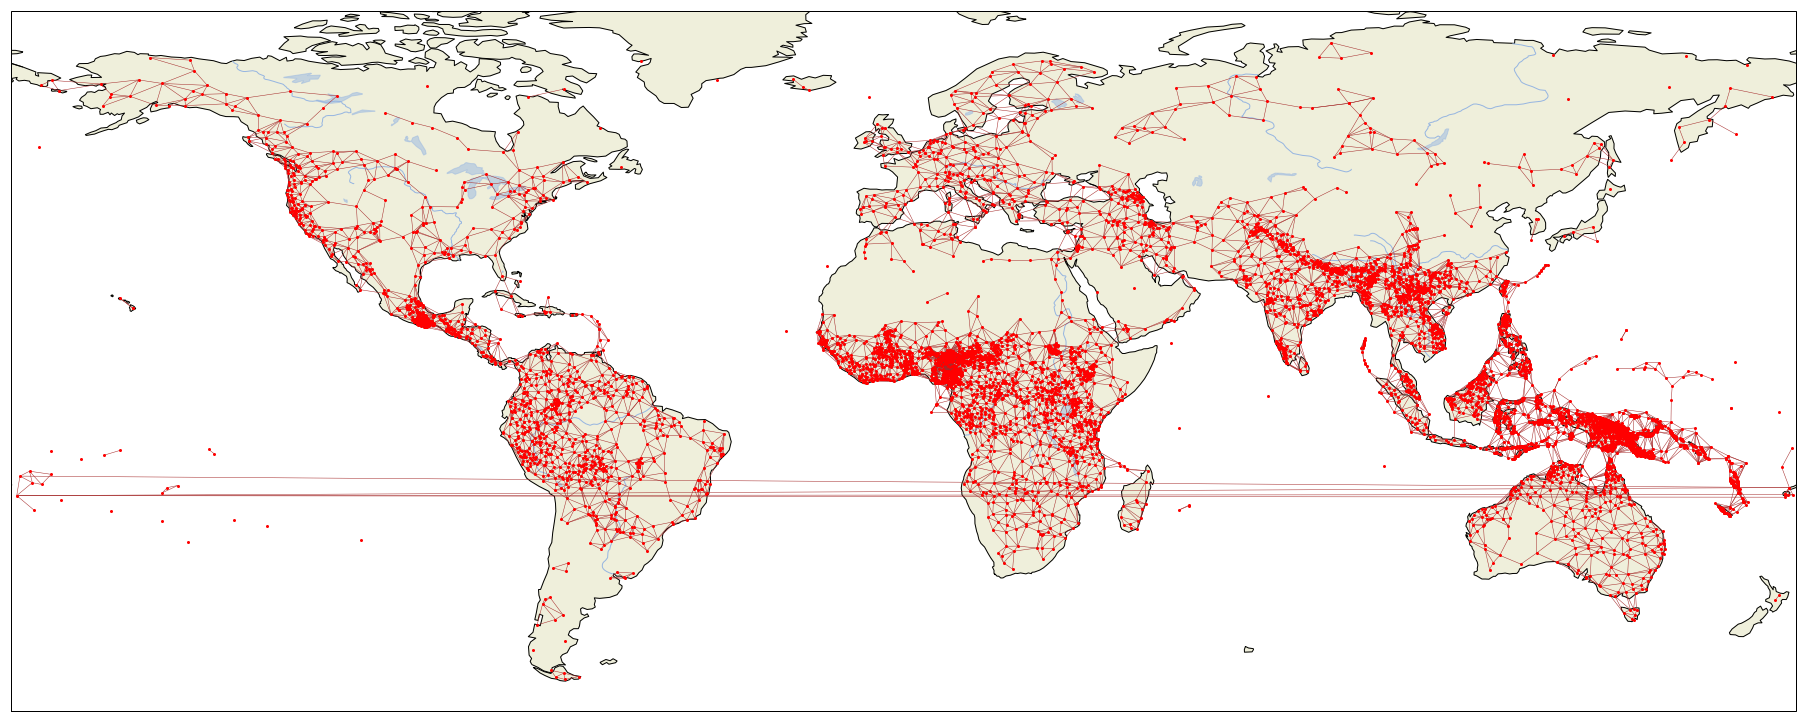

In [20]:
G = nx.Graph()
for k in range(len(indptr)-1):
    point_gltc = name_arr[k]
    G.add_node(point_gltc)
    neighbours = indices[indptr[k]:indptr[k+1]]
    for n in neighbours:
        neigh_gltc = name_arr[n]
        if type(vincenty(
            coords_dict[point_gltc],
            coords_dict[neigh_gltc]
        )) != type(None):
            if vincenty(
                coords_dict[point_gltc],
                coords_dict[neigh_gltc]
            ) <= 500:
                G.add_edge(point_gltc, neigh_gltc)
            
plot_graph(G)

In [21]:
# Enrich the graph with new edges:
# connect with major languages all languages
# that borrowed segments from them together
# with their neighbours.
colonial = ['stan1288', 'stan1293', 'arab1395',
            'indo1316', 'russ1263', 'macr1272',
            'stan1290', 'dutc1256']
borrowing_data = pd.read_csv('bsd_with_glottolog.csv')

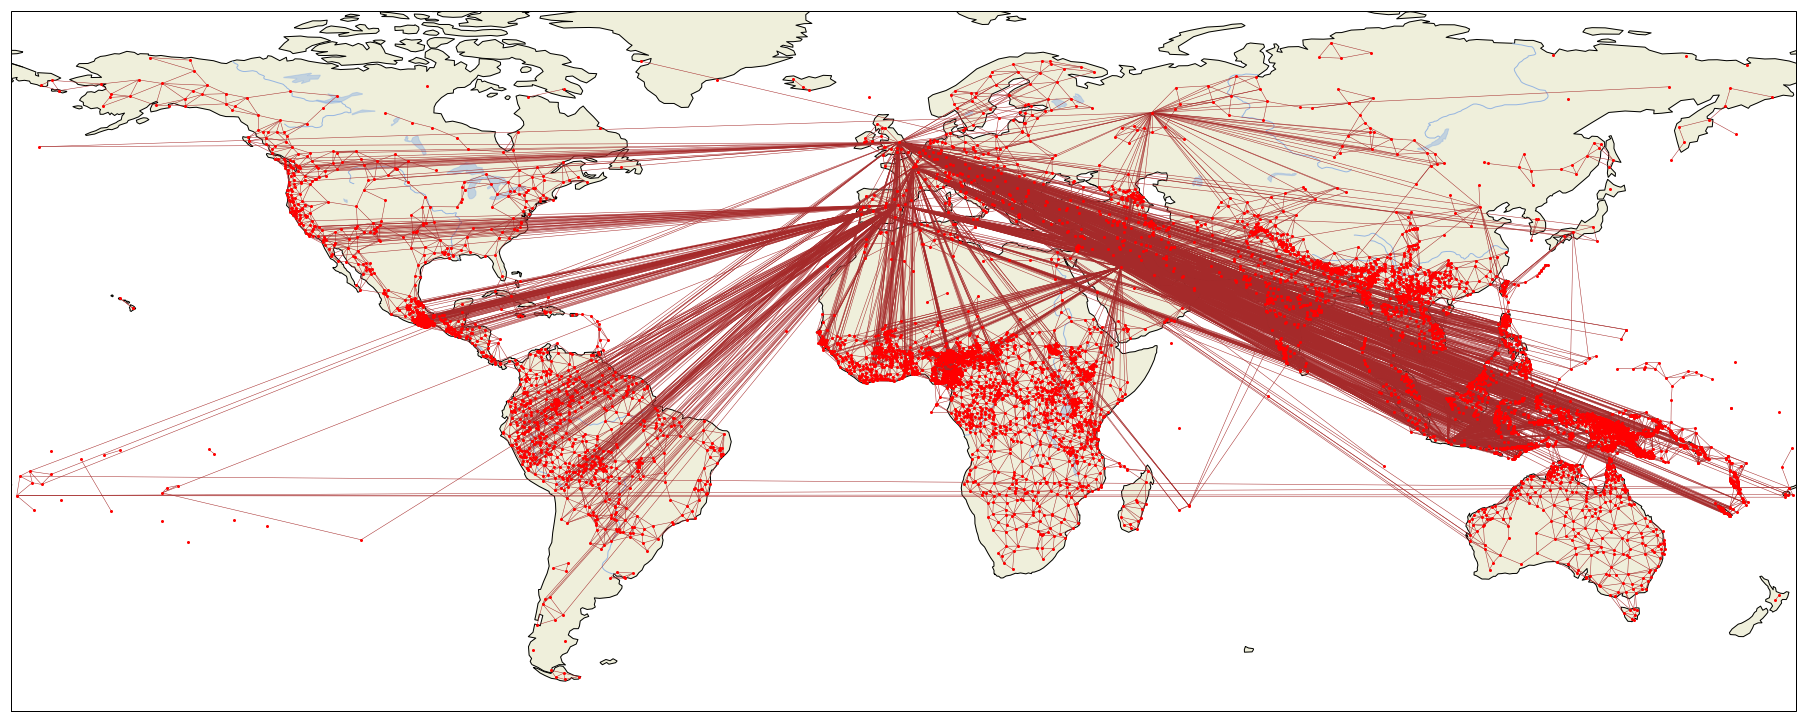

In [22]:
# The main graph-enrichment loop
langs_without_meta = set()
for row in borrowing_data.itertuples():
    gltc = row.Glottocode
    if gltc not in G.nodes():
        langs_without_meta.add(gltc)
        continue
    slgltcs_str = row.SourceLanguageGlottocode
    if pd.isna(slgltcs_str) or slgltcs_str == 'unknown' or slgltcs_str == '':
        continue
    slgltcs = re.split(r',\s*', slgltcs_str)
    for slgltc in slgltcs:
        # Correct abstract langs to standard varieties
        if slgltc == 'arab1395':
            slgltc_cor = 'stan1318'
        elif slgltc == 'macr1272':
            slgltc_cor = 'port1283'
        elif slgltc == 'nort3191':
            slgltc_cor = 'alge1239'
        elif slgltc not in G.nodes():
            continue
        else:
            slgltc_cor = slgltc
        G.add_edge(gltc, slgltc_cor)
        # For colonial languages, also connect
        # the neighbours.
        if slgltc in colonial:
            try:
                for ngltc in G.neighbors(gltc):
                    G.add_edge(ngltc, slgltc_cor)
            except KeyError:
                # The gltc doesn't have metadata;
                # have to skip
                langs_without_meta.add(gltc)
plot_graph(G)

## Create segbo coverage plot

In [23]:
def plot_graph2(G):
    # Create a line collection from the graph
#     lines = [[] for i in range(len(G.edges()))]
#     for i, edge in enumerate(G.edges()):
#         t, h = edge
#         lines[i] = [
#             rev_t(coords_dict[t]),
#             rev_t(coords_dict[h])
#         ]
#     lc = LineCollection(lines, colors='brown', linewidths=0.5)

    # Create points
    lats = []
    lons = []
    for coords_tuple in seg_coords_dict.values():
        lat, lon = coords_tuple
        lats.append(lat)
        lons.append(lon)

    fig = plt.figure(figsize=(32,20))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    # ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    # ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    plt.plot(lons, lats, marker='o', color='mediumblue', markersize=4,
              transform=ccrs.PlateCarree(), linewidth=0)
    ax.set_global()

#     ax.add_collection(lc)

In [24]:
seg_coords_dict = {}
for row in borrowing_data.itertuples():
    if pd.isna(row.latitude) or pd.isna(row.longitude):
        continue
    seg_coords_dict[row.glottocode] = (row.latitude, row.longitude)

In [25]:
cartesian_seg_coords_dict = {
    k: lat_lon_to_cartesian(*v) for k, v in seg_coords_dict.items()
}

In [26]:
seg_name_arr = sorted(seg_coords_dict)
seg_name_dict = {
    name: i for i, name in enumerate(seg_name_arr)
}
seg_points_arr = [cartesian_seg_coords_dict[lang] for lang in seg_name_arr]

In [27]:
seg_tri = Delaunay(seg_points_arr)

In [28]:
seg_indptr, seg_indices = seg_tri.vertex_neighbor_vertices

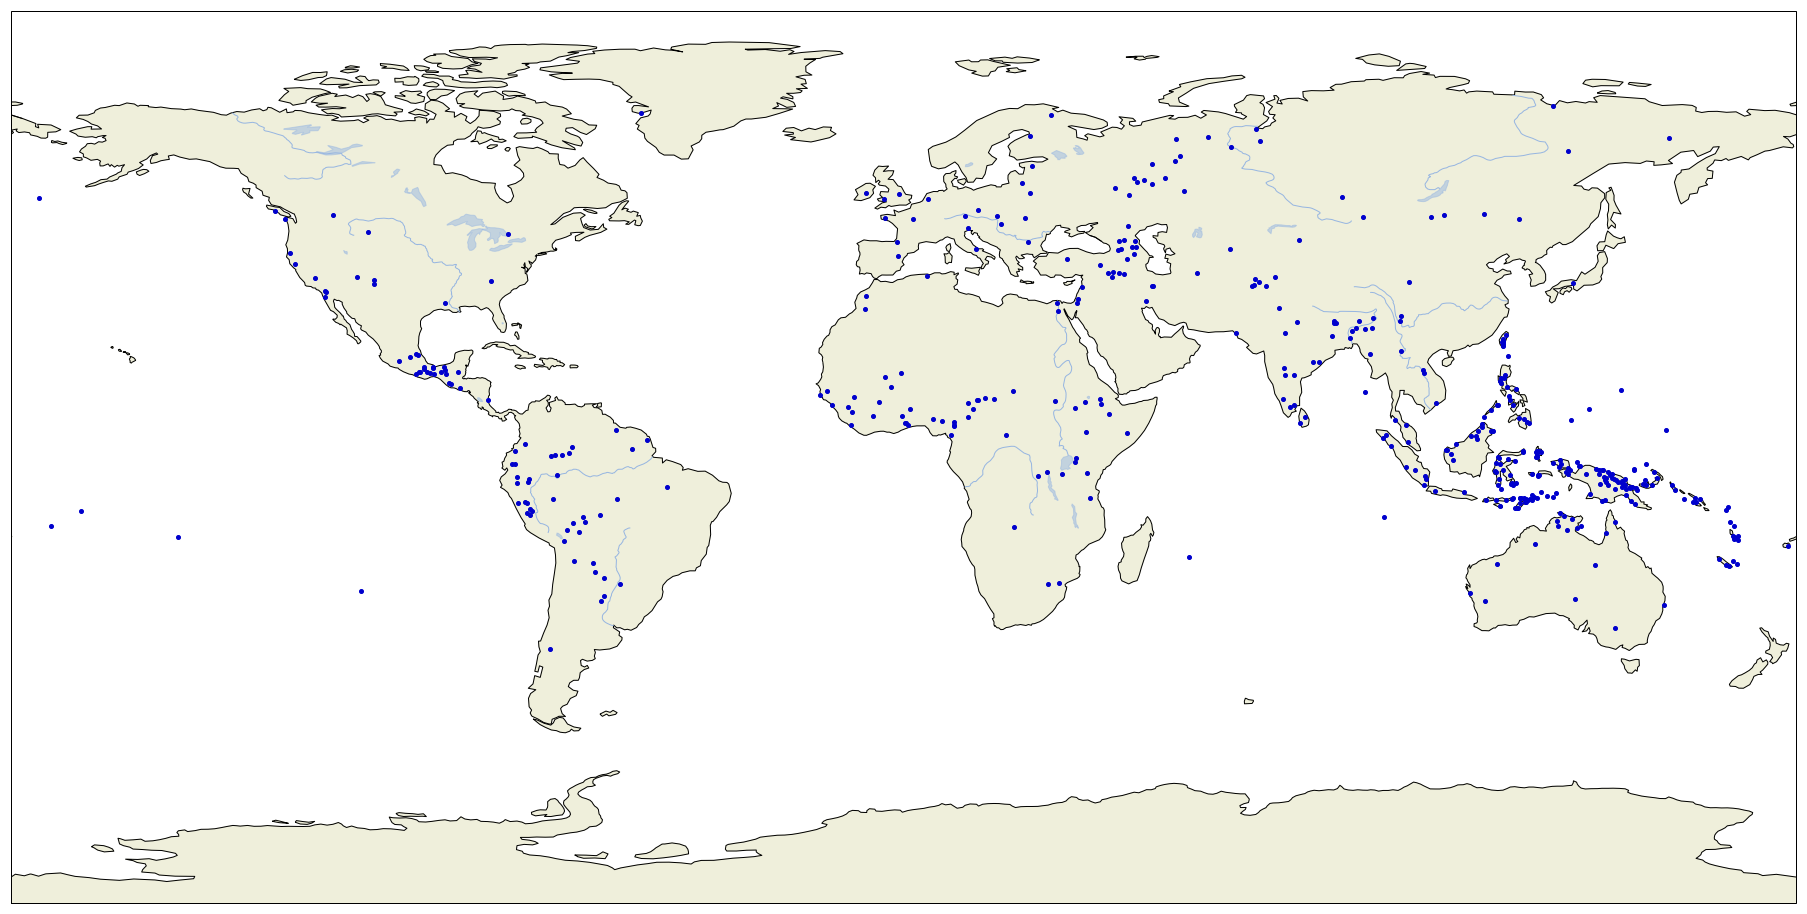

In [29]:
seg_G = nx.Graph()
for k in range(len(seg_indptr)-1):
    seg_point_gltc = seg_name_arr[k]
    seg_G.add_node(seg_point_gltc)
    seg_neighbours = seg_indices[seg_indptr[k]:seg_indptr[k+1]]
plot_graph2(seg_G)

## Feature study

In [69]:
feature_chars = {'aspiration': ['ʰ'],'palatalization': ['ʲ'],'labialization': ['ʷ'],'velarization': ['ˠ'],'pharyngealization': ['ˤ'],'retroflexes': ['ʈ','ɖ','ɳ','ɽ','ʂ','ʐ','ɻ','ɭ'],'ejectives': ['ʼ'],'implosives': ['ɓ','ɗ','ʄ','ɠ','ʛ'],'front rounded vowels': ['y','ʏ','ø','œ','ɶ','æ̹'],'nasalization': ['̃'],'breathy voice': ['̤'],'creaky voice': ['̰'], 'clicks': ['ʘ','ǀ','ǃ','ǂ','ǁ'], 'lateral fricatives': ['ɬ','ɮ'],'interdentals':['θ','ð'],'pharyngeals':['ʕ','ħ'],'uvulars':['q','ɢ','ɴ','ʀ','χ','ʁ'],'labial-velar plosives':['k͡p','k͜p','kp','ɡ͡b','ɡ͜b','ɡb','kʼpʼ','kʼ͡pʼ','kʼ͜pʼ','ɠ͡ɓ','ɠɓ','ɠ͜ɓ'],'postalveolars': ['ʃ','ʒ','t̠','d̠'],'affricates' : ['pɸ', 'pf', 'bv', 'bβ', 'ts', 'dz', 't̠ʃ', 'd̠ʒ', 'ʈʂ', 'ɖʐ', 'cç', 'ɟʝ', 'kx', 'ɡɣ', 'qχ', 'ɢʁ'],'labiodentals':['ɱ','f','v','ⱱ', 'ʋ']} # Each feature is defined by a set of characters

diacritics = '̥̬ʰ̹̜̟̠̩̯̈̽ʱ˞̤̰̼ʷʲˠˤ̴̝̞̘̙̪̺̻̃ⁿˡ̚ːˑ̆'


fcount = 0

for feature in feature_chars.keys(): # For every feature: 
    pattern_feature = list()
    for chars in feature_chars[feature]: # Make a RegEx pattern to look for segments with this feature
        pattern = r''
        for char in chars:
            pattern += char + '[' + diacritics + ']*'
        pattern_feature.append(pattern)

    fcount += 1
    print('Testing',feature,'- feature', fcount, 'of',len(feature_chars))
    pborrow_pnative = 0 # Counts languages WITH borrowed segments carrying the feature, and WITH native segments carrying the feature
    pborrow_mnative = 0 # Counts languages WITH borrowed segments segments carrying the feature, and WITHOUT native carrying the feature
    mborrow_mnative = 0 # Counts languages WITHOUT borrowed segments carrying the feature, and WITHOUT native segments carrying the feature
    mborrow_pnative = 0 # Counts languages WITHOUT borrowed segments carrying the feature, and WITH native segments carrying the feature
    
    filtered_borrowing_data = borrowing_data[np.array(list(np.any(borrowing_data['BorrowedSound'].str.contains(pattern) for pattern in pattern_feature))).T.tolist()] # Filter SegBo data by the ReGex
    filtered_borrowed_w_phoible = borrowed_w_phoible[np.array(list(np.any(borrowed_w_phoible['Phoneme'].str.contains(pattern) for pattern in pattern_feature))).T.tolist()] # Filter the intersection of SegBo and PHOIBLE ("segble") by the ReGex
    filtered_phoible = phoible[np.array(list(np.any(phoible['Phoneme'].str.contains(pattern) for pattern in pattern_feature))).T.tolist()] # Filter PHOIBLE data by the ReGex
    
    borr_glts = np.unique(filtered_borrowing_data[(filtered_borrowing_data['Result']!='other distributional change')]['Glottocode']) # glottocodes of languages that borrowed something with the feature, not as 'other distributional change'
    borr_ids = np.unique(borrowed_w_phoible[borrowed_w_phoible['Glottocode'].isin(borr_glts)]['InventoryID']) # list of PHOIBLE IDs of those languages
#     print(len(borr_ids))

#     check_list = list() # for debugging purposes
    for lang_id in np.unique(borr_ids): # For every language that borrowed a segment with the feature
        native_seg_count=len(filtered_borrowed_w_phoible[(filtered_borrowed_w_phoible['InventoryID'] == lang_id) & (filtered_borrowed_w_phoible['in_segbo'] != 1.0)]) # How many segments in segble from the language have character the feature and are native (=aren't on segbo)
        if native_seg_count > 0: # If the language has the feature natively:
            pborrow_pnative += 1          
#             lang_glt = np.unique(filtered_borrowed_w_phoible[(filtered_borrowed_w_phoible['InventoryID'] == lang_id)]['Glottocode'])
#             print('Borrowed with native:',lang_glt)
#             check_list.append(lang_glt)
        else: # If the language doesn't have the feature natively:
            pborrow_mnative += 1
#             lang_glt = np.unique(filtered_borrowed_w_phoible[(filtered_borrowed_w_phoible['InventoryID'] == lang_id)]['Glottocode'])
#             print('Borrowed without native:',lang_glt)
#             check_list.append(lang_glt)
            

    not_borr_ids = [x for x in np.unique(borrowed_w_phoible['InventoryID']) if x not in borr_ids] # all segble languages, that didn't borrow segments with the feature
    not_borr_glts = np.unique(borrowed_w_phoible[borrowed_w_phoible['InventoryID'].isin(not_borr_ids)]['Glottocode']) # their glottocodes
#     print(len(not_borr_glts))

    native_segble_glts = np.unique(((filtered_borrowed_w_phoible[(filtered_borrowed_w_phoible['in_segbo'] != 1)]['Glottocode']))) ## list of all langs in segble with native char
    native_only_ph_glts = [x for x in np.unique(filtered_phoible['Glottocode']) if x not in native_segble_glts] # list of all langs in PHOIBLE (and not segbo) with char
    native_glts = list()
    native_glts.extend(native_segble_glts)
    native_glts.extend(native_only_ph_glts)
    
    exp_not_borr_glts = list() # Make a list of languages exposed to the feature without borrowing it
    for glt in (native_glts): # For every language that has the feature:
        if glt in G.nodes:
            neighbors = list(G.neighbors(glt))
            exp_not_borr_glts.extend([x for x in neighbors if x in not_borr_glts]) # Add its neighbors to the exposed list (in case they didn't borrow a segment with the feature)
    #         print('neighbors of', glt)
    #         print(neighbors)
    #         print('neighbors not borrowed:')
    #         print([x for x in neighbors if x in not_borr_glts],'\n')

    exp_not_borr_ids = np.unique(borrowed_w_phoible[borrowed_w_phoible['Glottocode'].isin(exp_not_borr_glts)]['InventoryID']) # IDs of languages exposed to the feature without borrowing it
#     print(len(exp_not_borr_ids))

    for lang_id in list(np.unique(exp_not_borr_ids)): # for each language exposed to the feature without borrowing it:
        native_seg_count=len(filtered_borrowed_w_phoible[(filtered_borrowed_w_phoible['InventoryID'] == lang_id) & (filtered_borrowed_w_phoible['in_segbo'] != 1.0)]) # How many segments with the feature in the language are native (=aren't on segbo)
        if native_seg_count > 0: # If the language has the feature natively:
            mborrow_pnative += 1
#             print('Haven\'t borrowed, with native:',lang_id)
#             check_list.append(lang_id)

        else: # If the language doesn't have the feature natively:
            mborrow_mnative += 1
            
## Print contingency tables in a user-friendly format
#     print('Tested:',feature)
#     print('_______|-|+')
#     print('-|  ',mborrow_mnative,'\t   ',pborrow_mnative)
#     print('+|  ',mborrow_pnative,'\t   ',pborrow_pnative)

## Print contingency tables in a LaTeX-friendly format
    print('Tested:',feature)
    print(' & $-$native & $+$native \\\\ \cmidrule{2-3}')
    print('$-$borrowed & ',mborrow_mnative,'&',mborrow_pnative,' \\\\ \\relax')
    print('$+$borrowed & ',pborrow_mnative,'&',pborrow_pnative,' \\\\ \\bottomrule')

    
    oddsratio, pvalue = fisher_exact([[pborrow_pnative, mborrow_pnative], [pborrow_mnative, mborrow_mnative]]) # Perform Fisher's exact test
    if pvalue < 0.05:
        print ('\multicolumn{3}{l}{$p < 0.05$, odds ratio:', round(oddsratio,1),'}\\\\')
        print ('p =',pvalue, "odds ratio =", oddsratio,'\n')
    else:
        print ('\multicolumn{3}{l}{$p =',round(pvalue,3),'$}\\\\')
        print ('p =',pvalue, "odds ratio =", oddsratio,'\n')

Testing aspiration - feature 1 of 21
Tested: aspiration
 & $-$native & $+$native \\ \cmidrule{2-3}
$-$borrowed &  197 & 99  \\ \relax
$+$borrowed &  6 & 24  \\ \bottomrule
\multicolumn{3}{l}{$p < 0.05$, odds ratio: 8.0 }\\
p = 1.1832111312268e-06 odds ratio = 7.959595959595959 

Testing palatalization - feature 2 of 21
Tested: palatalization
 & $-$native & $+$native \\ \cmidrule{2-3}
$-$borrowed &  152 & 37  \\ \relax
$+$borrowed &  14 & 14  \\ \bottomrule
\multicolumn{3}{l}{$p < 0.05$, odds ratio: 4.1 }\\
p = 0.001233342056516423 odds ratio = 4.108108108108108 

Testing labialization - feature 3 of 21
Tested: labialization
 & $-$native & $+$native \\ \cmidrule{2-3}
$-$borrowed &  98 & 32  \\ \relax
$+$borrowed &  1 & 14  \\ \bottomrule
\multicolumn{3}{l}{$p < 0.05$, odds ratio: 42.9 }\\
p = 2.549134232136446e-07 odds ratio = 42.875 

Testing velarization - feature 4 of 21
Tested: velarization
 & $-$native & $+$native \\ \cmidrule{2-3}
$-$borrowed &  104 & 4  \\ \relax
$+$borrowed &  2